In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal
from collections import namedtuple
import matplotlib.pyplot as plt
from enum import Enum

In [2]:
Kouhou2 = namedtuple( 'kouhou2', ( 'NM', 'HB', 'src' ) )
Kouhou4 = namedtuple( 'kouhou4', ( 'NM_NM', 'HB_NM', 'NM_HB', 'HB_HB', 'src' ) )

# U値を計算する方法

断熱材のR値や厚さ、構法／工法、付加断熱の有無と付加断熱をした場合のR値等から、簡易的にU値を計算する方法を示す。

## 基本構成

壁・屋根／天井・床・ドア・窓の、1つ1つを部位という。  
1つの部位は、複数の部分を持ち、熱は並列的に複数の部分を通過する。  
壁・屋根／天井は、断熱材の充填が可能な一般部と、構造用の柱・梁など断熱材が充填できない熱橋部の2つの部分を持つ。  
床も、一般部と熱橋部の2つに分かれるが、根太レベルと大引きレベルの両方に断熱材を施工する場合は、構造的に根太と大引きが直角方向に配置されるため、床上側から床下側を見ると、  
・根太レベルが一般部で、大引きレベルも一般部、  
・根太レベルが熱橋部で、大引きレベルは一般部、  
・根太レベルが一般部で、大引きレベルも熱橋部、  
・根太レベルが熱橋部で、大引きレベルは熱橋部、  
の4つの部分を持つことがある。  
各部分は、複数の層を持ち、熱は直列的に複数の層を通過する。層として例えば、石膏ボード、合板、断熱材などが挙げられる。  
窓は、枠と可動部に分かれる。可動部はサッシとグレージングに分かれる。グレージングは透明であり、枠とサッシは不透明である。透明か不透明かで計算方法が異なるため、計算方法としては、枠とサッシの計算とグレージングの計算に分かれる。枠とサッシを合わせて建具と呼ぶ。  
ドアは、性格にはドアセットと言い、可動部分のみをドアと言う。ドアセットは枠とドアからなる。ドアは不透明なパネルのみで構成される場合と、グレージングがはめこまれる場合がある。  
計算方法は窓とドアで大きく異なるが、本来であれば大部分が透明な部分で構成されているか、大部分が不透明な部分で構成されているかで分類すべきである。従って、全面ガラスがはめこまれた框ドアは窓の計算方法が適用される。一方で、板戸などの不透明な窓はドアの計算方法が適用される。

## 1) 外壁(簡略法)

木造における外壁の面積比率を示す。

|                                                    | $a_{wall,NM}$ | $a_{wall,HB}$ | 層構造   |
|:--------------------------------------------------:|:-------------:|:-------------:|:--------:|
| 軸組構法で柱・間柱間に断熱する場合                 | 0.83          | 0.17          | 充填     |
| 軸組構法で柱・間柱間に断熱し付加断熱する場合       | 0.83          | 0.17          | 外張充填 |
| 枠組壁工法でたて枠間に断熱する場合                 | 0.77          | 0.23          | 充填     |
| 枠組壁工法でたて枠間に断熱し付加断熱する場合       | 0.77          | 0.23          | 外張充填 |
| 軸組み構法および枠組壁工法において外張断熱する場合 | 1.0           | 0.0           | 外張     |

In [3]:
def WallPart( kouhou ):
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    
    if   ( kouhou == 'Jik' ):       return Kouhou2( 0.83, 0.17, 'J' )
    elif ( kouhou == 'Jik_huka' ):  return Kouhou2( 0.83, 0.17, 'D' )
    elif ( kouhou == 'Waku' ):      return Kouhou2( 0.77, 0.23, 'J' )
    elif ( kouhou == 'Waku_huka' ): return Kouhou2( 0.77, 0.23, 'D'  )
    elif ( kouhou == 'Sotobari' ):  return Kouhou2( 1.0,  0.0,  'S' )
    else: raise ( 'value error of kouhou in U_wall_simple' )

In [4]:
WallPart('Jik')

kouhou2(NM=0.83, HB=0.17, src='J')

### 部位のU値

$ \begin{align} U_{wall} = a_{wall,NM} \times U_{wall,NM} + a_{wall,HB} \times U_{wall,HB} \end{align} $  

$ U_{wall} $: 壁のU値(W/m<sup>2</sup>K)  
$ a_{wall,NM} $: 壁の一般部の面積割合  
$ a_{wall,HB} $: 壁の熱橋部の面積割合  
$ U_{wall,NM} $: 壁の一般部のU値(W/m<sup>2</sup>K)  
$ U_{wall,HB} $: 壁の熱橋部のU値(W/m<sup>2</sup>K)  

In [5]:
def U_wall_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される
    
    wp = WallPart(kouhou)
    
    # R_NM: 壁の一般部のR値(m2K/W)
    # R_HB: 壁の熱橋部のR値(m2K/W)    
    R_NM, R_HB = R_wall_simple_part( wp.src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )

    # U_NM: 壁の一般部のU値(W/m2K)
    # U_HB: 壁の熱橋部のU値(W/m2K)    
    U_NM = U_wall_simple_part( gaiki, R_NM )
    U_HB = U_wall_simple_part( gaiki, R_HB )
    
    return wp.NM * U_NM + wp.HB * U_HB

### 部分のU値

一般部と熱橋部共通  
$ \begin{align} U_{wall} = \frac {1}{ R_{wall,se} + R_{wall,si} + R_{wall} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{wall,si}$): 0.11  
室外側($R_{wall,se}$): 0.04(通気層等なし), 0.11(通気層等あり)

In [6]:
def U_wall_simple_part( gaiki, R ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # R: （室内側・室外側表面の熱伝達抵抗を除いた）壁の熱抵抗(m2K/W)
    
    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.11
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.11
    
    # U: 壁のU値(W/m2K)
    return 1 / ( R_si + R_se + R )

### 部分のR値

充填断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } \end{align} $  
熱橋部のR値  
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } \end{align} $  

外張断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } \times 0.9 \end{align} $  
熱橋部のR値  
外張断熱の場合、胴縁はR値に低減係数0.9を乗じることで考慮しているため、計算上熱橋部はなしとして扱う。 

充填断熱＋外張断熱の場合  
一般部のR値  
$ \begin{align} R_{wall,NM} = \frac{ \lambda_{wall,Ins} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  
熱橋部のR値  
$ \begin{align} R_{wall,HB} = \frac{ \lambda_{wood} }{ l_{wall,Ins} } + \frac{ \lambda_{wall,Ins2} }{ l_{wall,Ins2} } \times 0.9 \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)  
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12  
係数0.9は、外張工法の胴縁等による熱抵抗の減少を表す係数

In [7]:
def R_wall_simple_part( src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # src: 構造 'J'=充填断熱, 'S'=外張断熱 'D':充填かつ外張断熱
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) src = 'J'&'S' の場合はこの値は無視される
    
    lambda_wood = 0.12

    if( src == 'J' ):
        R_NM = thick_ins / lambda_ins
        R_HB = thick_ins / lambda_wood
    elif( src == 'S' ):
        R_NM = thick_ins / lambda_ins * 0.9
        R_HB = 0.0
    elif( src == 'D' ):
        R_NM = thick_ins / lambda_ins  + thick_ins2 / lambda_ins2 * 0.9
        R_HB = thick_ins / lambda_wood + thick_ins2 / lambda_ins2 * 0.9
    else:
        raise( 'wrong src value in U_wall_simple_part' )
    
    return ( R_NM, R_HB )

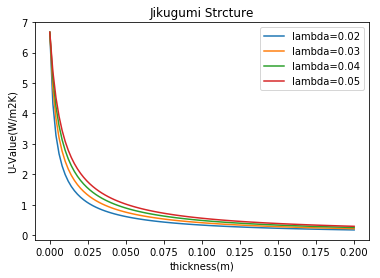

In [8]:
t = np.linspace(0,0.2,100)

plt.xlabel('thickness(m)')
plt.ylabel('U-Value(W/m2K)')
plt.title('Jikugumi Strcture')
for l in [0.02,0.03,0.04,0.05]:
    plt.plot( t, U_wall_simple( True, 'Jik', l, t, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()
plt.show()

### テスト

In [9]:
test_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Jik'       : 軸組構法で柱・間柱間に断熱する場合
    #   'Jik_huka'  : 軸組構法で柱・間柱間に断熱し付加断熱する場合
    #   'Waku'      : 枠組壁工法でたて枠間に断熱する場合
    #   'Waku_huka' : 枠組壁工法でたて枠間に断熱し付加断熱する場合
    #   'Sotobari'  : 軸組み構法および枠組壁工法において外張断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される

test_input.append( [ True,  'Jik'       , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Jik_huka'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Waku'      , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Waku_huka' , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Sotobari'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Jik'       , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Jik_huka'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Waku'      , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Waku_huka' , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Sotobari'  , 0.042, 0.05, 0.042, 0.05] )

In [10]:
test_output = []
for t in test_input:
    test_output.append( U_wall_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_output

[0.919182948490231,
 0.4479054271218348,
 0.9803050882875354,
 0.4596567299524783,
 0.8187134502923977,
 0.8554694542742098,
 0.4339466342708951,
 0.9071714668523815,
 0.4448985004046975,
 0.7743362831858407]

### 簡易法2との比較

今回示す方法とは全く別に、「簡易法2」が存在し、U値は以下の式で表される。  
$ \begin{align} U = \frac{1}{R_{ins}} + U_r \end{align} $

$R_{ins}$: 断熱材のR値(m<sup>2</sup>K/W)  
$U_r$: 補正貫流率(W/m<sup>2</sup>K)

補正貫流率は断熱工法等に応じて以下の値をとる。

| 断熱工法等                                     | 軸組構法 | 枠組壁工法 |
|:----------------------------------------------:|:--------:|:----------:|
| 充填断熱（柱・間柱間に断熱）する場合           | 0.09     | 0.13       |
| 充填断熱（柱・間柱間に断熱）し付加断熱する場合 | 0.09     | 0.13       |
| 土壁で外張断熱する場合                         | 0.04     | 0.04       |
| 土壁以外で外張断熱する場合                     | 0.02     | 0.02       |

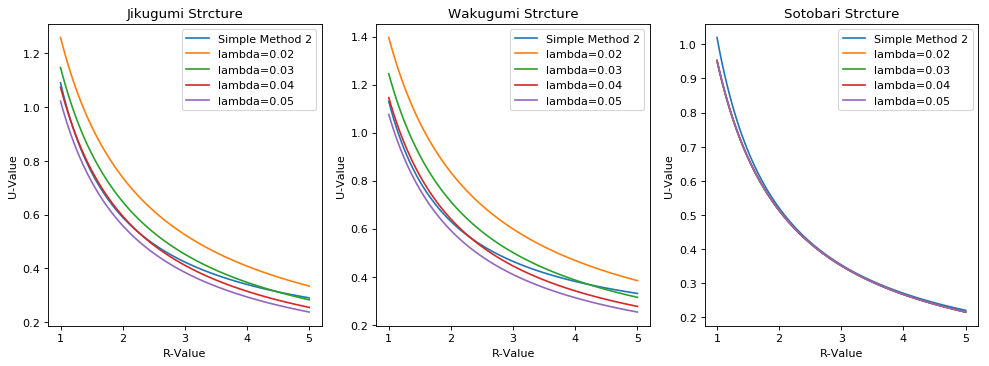

In [11]:
plt.figure(figsize=(15,5),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(131)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jikugumi Strcture')
plt.plot( R, 1/R+0.09, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Jik', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(132)
plt.title('Wakugumi Strcture')
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Waku', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(133)
plt.title('Sotobari Strcture')
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.plot( R, 1/R+0.02, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_wall_simple( True, 'Sotobari', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()

## 2) 屋根または天井(簡略法)

木造における屋根または天井の面積比率を示す。

|                                                      | $a_{roof,NM}$ | $a_{roof,HB}$ | 層構造   |
|:----------------------------------------------------:|:-------------:|:-------------:|:--------:|
| 天井断熱工法において梁や桁間に断熱する場合           | 0.87          | 0.13          | 充填     |
| 天井断熱工法において天井一面に断熱する場合           | 1.0           | 0.0           | 充填     |
| 屋根断熱工法においてたるき間に断熱する場合           | 0.86          | 0.14          | 充填     |
| 屋根断熱工法において外張断熱する場合                 | 1.0           | 0.0           | 外張     |
| 屋根断熱工法においてたるき間に断熱し付加断熱する場合 | 0.86          | 0.14           | 外張充填 |

In [12]:
def RoofPart( kouhou ):
    # kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    
    if   ( kouhou == 'Hari_Keta' ):   return Kouhou2( 0.87, 0.13, 'J' )
    elif ( kouhou == 'Tenjou' ):      return Kouhou2( 1.0,  0.0,  'J' )
    elif ( kouhou == 'Taruki' ):      return Kouhou2( 0.86, 0.14, 'J' )
    elif ( kouhou == 'Sotobari' ):    return Kouhou2( 1.0,  0.0,  'S' )
    elif ( kouhou == 'Taruki_huka' ): return Kouhou2( 0.86, 0.14, 'D' )
    else: raise ( 'value error of kouhou in Roof_Part' )

In [13]:
RoofPart('Hari_Keta')

kouhou2(NM=0.87, HB=0.13, src='J')

### 部位のU値

$ \begin{align} U_{roof} = a_{roof,NM} \times U_{roof,NM} + a_{roof,HB} \times U_{roof,HB} \end{align} $  

$ U_{roof} $: 屋根・天井のU値(W/m<sup>2</sup>K)  
$ a_{roof,NM} $: 屋根・天井の一般部の面積割合  
$ a_{roof,HB} $: 屋根・天井の熱橋部の面積割合  
$ U_{roof,NM} $: 屋根・天井の一般部のU値(W/m<sup>2</sup>K)  
$ U_{roof,HB} $: 屋根・天井の熱橋部のU値(W/m<sup>2</sup>K)  

In [14]:
def U_roof_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される
    
    wp = RoofPart(kouhou)
    
    # R_NM: 壁の一般部のR値(m2K/W)
    # R_HB: 壁の熱橋部のR値(m2K/W)
    R_NM, R_HB = R_roof_simple_part( wp.src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )

    # U_NM: 壁の一般部のU値(W/m2K)
    # U_HB: 壁の熱橋部のU値(W/m2K)
    U_NM = U_roof_simple_part( gaiki, R_NM )
    U_HB = U_roof_simple_part( gaiki, R_HB )
    
    return wp.NM * U_NM + wp.HB * U_HB

### 部分のU値

一般部と熱橋部共通  
$ \begin{align} U_{roof} = \frac {1}{ R_{roof,se} + R_{roof,si} + R_{roof} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{roof,si}$): 0.09  
室外側($R_{roof,se}$): 0.04(通気層等なし), 0.09(通気層・小屋裏等あり)

In [15]:
def U_roof_simple_part( gaiki, R ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # R: （室内側・室外側表面の熱伝達抵抗を除いた）屋根・天井の熱抵抗(m2K/W)
    
    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.09
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.09
    
    # U: 壁の部分のU値(W/m2K)
    return 1 / ( R_si + R_se + R )

### 部分のR値

充填断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } \end{align} $  
熱橋部のR値  
$ \begin{align} R_{roof,HB} = \frac{ \lambda_{wood} }{ l_{roof,Ins} } \end{align} $  

外張断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } \times 0.9 \end{align} $  
熱橋部のR値  
外張断熱の場合、胴縁はR値に低減係数0.9を乗じることで考慮しているため、計算上熱橋部はなしとして扱う。 

充填断熱＋外張断熱の場合  
一般部のR値  
$ \begin{align} R_{roof,NM} = \frac{ \lambda_{roof,Ins} }{ l_{roof,Ins} } + \frac{ \lambda_{roof,Ins2} }{ l_{roof,Ins2} } \times 0.9 \end{align} $  
熱橋部のR値  
$ \begin{align} R_{roof,HB} = \frac{ \lambda_{wood} }{ l_{roof,Ins} } + \frac{ \lambda_{roof,Ins2} }{ l_{roof,Ins2} } \times 0.9 \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)  
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12  
係数0.9は、外張工法の胴縁等による熱抵抗の減少を表す係数

In [16]:
def R_roof_simple_part( src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # src: 構造 'J'=充填断熱, 'S'=外張断熱 'D':充填かつ外張断熱
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) src = 'J'&'S' の場合はこの値は無視される
    
    lambda_wood = 0.12

    if( src == 'J' ):
        R_NM = thick_ins / lambda_ins
        R_HB = thick_ins / lambda_wood
    elif( src == 'S' ):
        R_NM = thick_ins / lambda_ins * 0.9
        R_HB = 0.0
    elif( src == 'D' ):
        R_NM = thick_ins / lambda_ins  + thick_ins2 / lambda_ins2 * 0.9
        R_HB = thick_ins / lambda_wood + thick_ins2 / lambda_ins2 * 0.9
    else:
        raise( 'wrong src value in U_wall_simple_part' )

    return ( R_NM, R_HB )

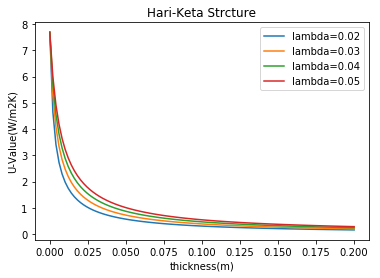

In [17]:
t = np.linspace(0,0.2,100)

plt.xlabel('thickness(m)')
plt.ylabel('U-Value(W/m2K)')
plt.title('Hari-Keta Strcture')
for l in [0.02,0.03,0.04,0.05]:
    plt.plot( t, U_roof_simple( True, 'Hari_Keta', l, t, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()
plt.show()

### テスト

In [18]:
test_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Hari_Keta'   : 天井断熱工法において梁や桁間に断熱する場合
    #   'Tenjou'      : 天井断熱工法において天井一面に断熱する場合
    #   'Taruki'      : 屋根断熱工法においてたるき間に断熱する場合
    #   'Sotobari'    : 屋根断熱工法において外張断熱する場合
    #   'Taruki_huka' : 屋根断熱工法においてたるき間に断熱し付加断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される

test_input.append( [ True,  'Hari_Keta'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Tenjou'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Taruki'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Sotobari'   , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ True,  'Taruki_huka', 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Hari_Keta'  , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Tenjou'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Taruki'     , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Sotobari'   , 0.042, 0.05, 0.042, 0.05] )
test_input.append( [ False, 'Taruki_huka', 0.042, 0.05, 0.042, 0.05] )

In [19]:
test_output = []
for t in test_input:
    test_output.append( U_roof_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_output

[0.8966581056001688,
 0.7573025604038947,
 0.9073777629229591,
 0.8323424494649226,
 0.4460675712206487,
 0.8526929393084118,
 0.7296733842946491,
 0.8621559820017781,
 0.7990867579908676,
 0.43611214902492756]

### 簡易法2との比較

今回示す方法とは全く別に、「簡易法2」が存在し、U値は以下の式で表される。  
$ \begin{align} U = \frac{1}{R_{ins}} + U_r \end{align} $

$R_{ins}$: 断熱材のR値(m<sup>2</sup>K/W)  
$U_r$: 補正貫流率(W/m<sup>2</sup>K)

補正貫流率は断熱工法等に応じて以下の値をとる。

| 断熱工法等                           |      |
|:------------------------------------:|:----:|
| 天井断熱で桁・梁間に断熱する場合     | 0.05 |
| 屋根断熱で充填断熱する場合           | 0.11 |
| 屋根断熱で充填断熱し付加断熱する場合 | 0.11 |
| 屋根断熱で外張断熱する場合           | 0.02 |

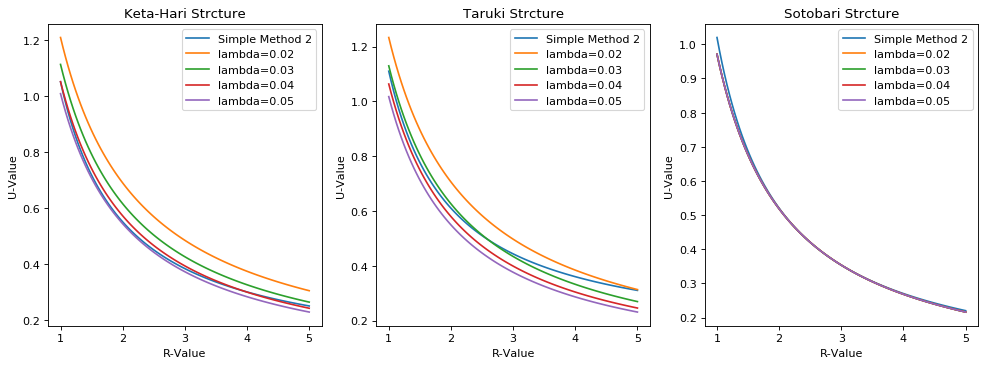

In [20]:
plt.figure(figsize=(15,5),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(131)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Keta-Hari Strcture')
plt.plot( R, 1/R+0.05, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Hari_Keta', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(132)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Taruki Strcture')
plt.plot( R, 1/R+0.11, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Taruki', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(133)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Sotobari Strcture')
plt.plot( R, 1/R+0.02, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_roof_simple( True, 'Sotobari', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()

## 3) 床(簡略法)

木造における屋根または天井の面積比率を示す。

|                                                                      | $a_{floor,NMNM}$ | $a_{floor,HBNM}$ | $a_{floor,NMHB}$ | $a_{floor,HBHB}$ | 層構造   |
|:--------------------------------------------------------------------:|:----:|:----:|:----:|:----:|:--:|
| 軸組構法において床梁工法を採用し根太間に断熱する場合                 | 0.8  | 0.2  | 0.0  | 0.0  | SL |
| 軸組構法の束立大引工法であって根太間に断熱する場合                   | 0.8  | 0.2  | 0.0  | 0.0  | SL |
| 軸組構法において束立大引工法を採用し大引間に断熱する場合             | 0.85 | 0.15 | 0.0  | 0.0  | SL |
| 軸組構法において束立大引工法を採用し根太間および大引間に断熱する場合 | 0.72 | 0.13 | 0.12 | 0.03 | DL |
| 軸組構法において剛床工法を採用する場合                               | 0.85 | 0.15 | 0.0  | 0.0  | SL |
| 軸組構法の床梁土台同面工法であって根太間に断熱する場合               | 0.7  | 0.3  | 0.0  | 0.0  | SL |
| 枠組壁工法であって根太間に断熱する場合                               | 0.87 | 0.13 | 0.0  | 0.0  | SL |

In [21]:
def FloorPart( kouhou ):
    # kouhou: 構法・工法
    #   'Jiku_yukahari_neda'      : 軸組構法の床梁工法であって根太間に断熱する場合
    #   'Jiku_tukadate_neda'      : 軸組構法の束立大引工法であって根太間に断熱する場合
    #   'Jiku_tukadate_obiki'     : 軸組構法の束立大引工法であって大引間に断熱する場合
    #   'Jiku_tukadate_nedaobiki' : 軸組構法の束立大引工法であって根太間及び大引間に断熱する場合
    #   'Jiku_goushou'            : 軸組構法の剛床工法
    #   'Jiku_douzura'            : 軸組構法の床梁土台同面工法であって根太間に断熱する場合
    #   'Waku_neda'               : 枠組壁工法であって根太間に断熱する場合

    # SL: 1層  DL:2層
    if   ( kouhou == 'Jiku_yukahari_neda' ):      return Kouhou4( 0.8,  0.2,  0.0,  0.0,  'SL' )
    elif ( kouhou == 'Jiku_tukadate_neda' ):      return Kouhou4( 0.8,  0.2,  0.0,  0.0,  'SL' )
    elif ( kouhou == 'Jiku_tukadate_obiki' ):     return Kouhou4( 0.85, 0.15, 0.0,  0.0,  'SL' )
    elif ( kouhou == 'Jiku_tukadate_nedaobiki' ): return Kouhou4( 0.72, 0.13, 0.12, 0.03, 'DL' )
    elif ( kouhou == 'Jiku_goushou' ):            return Kouhou4( 0.85, 0.15, 0.0,  0.0,  'SL' )
    elif ( kouhou == 'Jiku_douzura' ):            return Kouhou4( 0.7,  0.3,  0.0,  0.0,  'SL' )
    elif ( kouhou == 'Waku_neda' ):               return Kouhou4( 0.87, 0.13, 0.0,  0.0,  'SL' )
    else: raise ( 'value error of kouhou in FloorPart' )

In [22]:
FloorPart('Jiku_yukahari_neda')

kouhou4(NM_NM=0.8, HB_NM=0.2, NM_HB=0.0, HB_HB=0.0, src='SL')

### 部位のU値

$ \begin{align} U_{floor} = a_{floor,NM,NM} \times U_{floor,NM,NM} + a_{floor,HB,NM} \times U_{floor,HB,NM} + a_{floor,NM,HB} \times U_{floor,NM,HB} + a_{floor,HB,HB} \times U_{floor,HB,HB} \end{align} $  

$ U_{floor} $: 床のU値(W/m<sup>2</sup>K)  
$ a_{floor,NM,NM} $: 床の1層目が一般部で2層目が一般部の面積割合  
$ a_{floor,HB,NM} $: 床の1層目が熱橋部で2層目が一般部の面積割合  
$ a_{floor,NM,HB} $: 床の1層目が一般部で2層目が熱橋部の面積割合  
$ a_{floor,HB,HB} $: 床の1層目が熱橋部で2層目が熱橋部の面積割合  
$ U_{floor,NM,NM} $: 床の1層目が一般部で2層目が一般部のU値(W/m<sup>2</sup>K)  
$ U_{floor,HB,NM} $: 床の1層目が熱橋部で2層目が一般部のU値(W/m<sup>2</sup>K)  
$ U_{floor,NM,HB} $: 床の1層目が一般部で2層目が熱橋部のU値(W/m<sup>2</sup>K)  
$ U_{floor,HB,HB} $: 床の1層目が熱橋部で2層目が熱橋部のU値(W/m<sup>2</sup>K)  

In [23]:
def U_floor_simple( gaiki, kouhou, lambda_ins, thick_ins, lambda_ins2, thick_ins2  ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # kouhou: 構法・工法
    #   'Jiku_yukahari_neda'      : 軸組構法の床梁工法であって根太間に断熱する場合
    #   'Jiku_tukadate_neda'      : 軸組構法の束立大引工法であって根太間に断熱する場合
    #   'Jiku_tukadate_obiki'     : 軸組構法の束立大引工法であって大引間に断熱する場合
    #   'Jiku_tukadate_nedaobiki' : 軸組構法の束立大引工法であって根太間及び大引間に断熱する場合
    #   'Jiku_goushou'            : 軸組構法の剛床工法
    #   'Jiku_douzura'            : 軸組構法の床梁土台同面工法であって根太間に断熱する場合
    #   'Waku_neda'               : 枠組壁工法であって根太間に断熱する場合
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'J'&'S' の場合はこの値は無視される
    
    wp = FloorPart(kouhou)
    
    R_NM_NM, R_HB_NM, R_NM_HB, R_HB_HB = R_floor_simple_part( wp.src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 )

    U_NM_NM = U_floor_simple_part( gaiki, R_NM_NM )
    U_HB_NM = U_floor_simple_part( gaiki, R_HB_NM )
    U_NM_HB = U_floor_simple_part( gaiki, R_NM_HB )
    U_HB_HB = U_floor_simple_part( gaiki, R_HB_HB )
    
    return wp.NM_NM * U_NM_NM + wp.HB_NM * U_HB_NM + wp.NM_HB * U_NM_HB + wp.HB_HB * U_HB_HB

### 部分のU値

一般部＋一般部、熱橋部＋一般部、一般部＋熱橋部、熱橋部＋熱橋部、すべてに共通  
$ \begin{align} U_{floor} = \frac {1}{ R_{floor,se} + R_{floor,si} + R_{floor} } \end{align} $  

表面熱伝達抵抗(m<sup>2</sup>K/W)  
室内側($R_{floor,si}$): 0.09  
室外側($R_{floor,se}$): 0.04(床裏等以外), 0.15(床裏等)

In [24]:
def U_floor_simple_part( gaiki, R ):
    # gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # R: （室内側・室外側表面の熱伝達抵抗を除いた）床の熱抵抗(m2K/W)
    
    # 室内側熱伝達抵抗(m2K/W)
    R_si = 0.15
    
    # 室外側熱伝達抵抗(m2K/W)
    R_se = 0.04 if gaiki else 0.15
    
    # U: 床の部分のU値(W/m2K)
    return 1 / ( R_si + R_se + R )

### 床のR値

断熱層が1層の場合  
一般部＋一般部のR値  
$ \begin{align} R_{floor,NM,NM} = \frac{ \lambda_{floor,Ins} }{ l_{floor,Ins} } \end{align} $  
熱橋部＋一般部のR値  
$ \begin{align} R_{floor,HB,NM} = \frac{ \lambda_{wood} }{ l_{floor,Ins} } \end{align} $  
一般部＋熱橋部のR値  
$ \begin{align} R_{floor,NM,HB} = 0 \end{align} $  
熱橋部＋熱橋部のR値  
$ \begin{align} R_{floor,HB,HB} = 0 \end{align} $  

断熱層が2層の場合  
一般部＋一般部のR値  
$ \begin{align} R_{floor,NM,NM} = \frac{ \lambda_{floor,Ins} }{ l_{floor,Ins} } + \frac{ \lambda_{floor,Ins2} }{ l_{floor,Ins2} } \end{align} $  
熱橋部＋一般部のR値  
$ \begin{align} R_{floor,HB,NM} = \frac{ \lambda_{wood} }{ l_{floor,Ins} } + \frac{ \lambda_{floor,Ins2} }{ l_{floor,Ins2} } \end{align} $  
一般部＋熱橋部のR値  
$ \begin{align} R_{floor,NM,HB} = \frac{ \lambda_{floor,Ins} }{ l_{floor,Ins} } + \frac{ \lambda_{wood} }{ l_{floor,Ins2} } \end{align} $  
熱橋部＋熱橋部のR値  
$ \begin{align} R_{floor,HB,HB} = \frac{ \lambda_{wood} }{ l_{floor,Ins} } + \frac{ \lambda_{wood} }{ l_{floor,Ins2} } \end{align} $  

$\lambda$: 熱伝導率(W/mK)  
$l$: 断熱材の厚さ(m)  
Ins: 断熱材  
Ins2: 2層目の断熱材(充填断熱時の外張断熱)  
wood: 天然木材  

天然木材の熱伝導率は0.12

In [25]:
def R_floor_simple_part( src, lambda_ins, thick_ins, lambda_ins2, thick_ins2 ):
    # src: 構造 'SL'=1層, 'DL'=2層
    # lambda_ins: 断熱材の熱伝導率(W/mK)
    # thick_ins: 断熱材の厚さ(m)
    # lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) src = 'J'&'S' の場合はこの値は無視される
    # thick_ins2: 2層目の断熱材の厚さ(m) src = 'J'&'S' の場合はこの値は無視される
    
    lambda_wood = 0.12

    if( src == 'SL' ):
        R_NM_NM = thick_ins / lambda_ins
        R_HB_NM = thick_ins / lambda_wood
        R_NM_HB = 0
        R_HB_HB = 0
    elif( src == 'DL' ):
        R_NM_NM = thick_ins / lambda_ins  + thick_ins2 / lambda_ins2
        R_HB_NM = thick_ins / lambda_wood + thick_ins2 / lambda_ins2
        R_NM_HB = thick_ins / lambda_ins  + thick_ins2 / lambda_wood
        R_HB_HB = thick_ins / lambda_wood + thick_ins2 / lambda_wood
    else:
        raise( 'wrong src value in U_wall_simple_part' )

    return ( R_NM_NM, R_HB_NM, R_NM_HB, R_HB_HB )

In [26]:
U_floor_simple( True, 'Jiku_yukahari_neda', 0.03, 0.1, 0, 0 )

0.42249744991509985

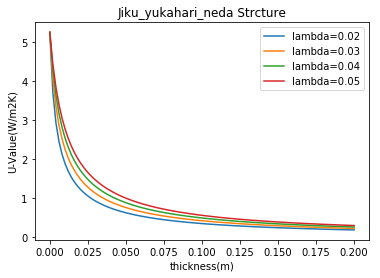

In [27]:
t = np.linspace(0,0.2,100)

plt.xlabel('thickness(m)')
plt.ylabel('U-Value(W/m2K)')
plt.title('Jiku_yukahari_neda Strcture')
for l in [0.02,0.03,0.04,0.05]:
    plt.plot( t, U_floor_simple( True, 'Jiku_yukahari_neda', l, t, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()
plt.show()

### テスト

In [28]:
test_floor_input = []

    # 第1引数 gaiki: 外気の種類　直接面している場合は True それ以外（通気層など）はFalse
    # 第2引数 kouhou: 構法・工法
    #   'Jiku_yukahari_neda'      : 軸組構法の床梁工法であって根太間に断熱する場合
    #   'Jiku_tukadate_neda'      : 軸組構法の束立大引工法であって根太間に断熱する場合
    #   'Jiku_tukadate_obiki'     : 軸組構法の束立大引工法であって大引間に断熱する場合
    #   'Jiku_tukadate_nedaobiki' : 軸組構法の束立大引工法であって根太間及び大引間に断熱する場合
    #   'Jiku_goushou'            : 軸組構法の剛床工法
    #   'Jiku_douzura'            : 軸組構法の床梁土台同面工法であって根太間に断熱する場合
    #   'Waku_neda'               : 枠組壁工法であって根太間に断熱する場合
    # 第3引数 lambda_ins: 断熱材の熱伝導率(W/mK)
    # 第4引数 thick_ins: 断熱材の厚さ(m)
    # 第5引数 lambda_ins2: 2層目の断熱材の熱伝導率(W/mK) wp.src = 'SL' の場合はこの値は無視される
    # 第6引数 thick_ins2: 2層目の断熱材の厚さ(m) wp.src = 'SL' の場合はこの値は無視される
    
test_floor_input.append( [ True,  'Jiku_yukahari_neda'      , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Jiku_tukadate_neda'      , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Jiku_tukadate_obiki'     , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Jiku_tukadate_nedaobiki' , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Jiku_goushou'            , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Jiku_douzura'            , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ True,  'Waku_neda'               , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_yukahari_neda'      , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_tukadate_neda'      , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_tukadate_obiki'     , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_tukadate_nedaobiki' , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_goushou'            , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Jiku_douzura'            , 0.042, 0.05, 0.042, 0.05] )
test_floor_input.append( [ False, 'Waku_neda'               , 0.042, 0.05, 0.042, 0.05] )

In [29]:
test_floor_output = []
for t in test_floor_input:
    test_floor_output.append( U_floor_simple( t[0], t[1], t[2], t[3], t[4], t[5] ) )
test_floor_output

[0.9091805055930617,
 0.9091805055930617,
 0.86298230917065,
 0.4484775203011046,
 0.86298230917065,
 1.001576898437885,
 0.8445030306016853,
 0.8158109814993684,
 0.8158109814993684,
 0.7795898655174975,
 0.4261180094206242,
 0.7795898655174975,
 0.8882532134631101,
 0.7651014191247492]

### 簡易法2との比較

今回示す方法とは全く別に、「簡易法2」が存在し、U値は以下の式で表される。  
$ \begin{align} U = \frac{1}{R_{ins}} + U_r \end{align} $

$R_{ins}$: 断熱材のR値(m<sup>2</sup>K/W)  
$U_r$: 補正貫流率(W/m<sup>2</sup>K)

補正貫流率は断熱工法等に応じて以下の値をとる。

| 断熱工法等 |      |
|:----------:|:----:|
| 軸組構法   | 0.13 |
| 枠組壁工法 | 0.08 |

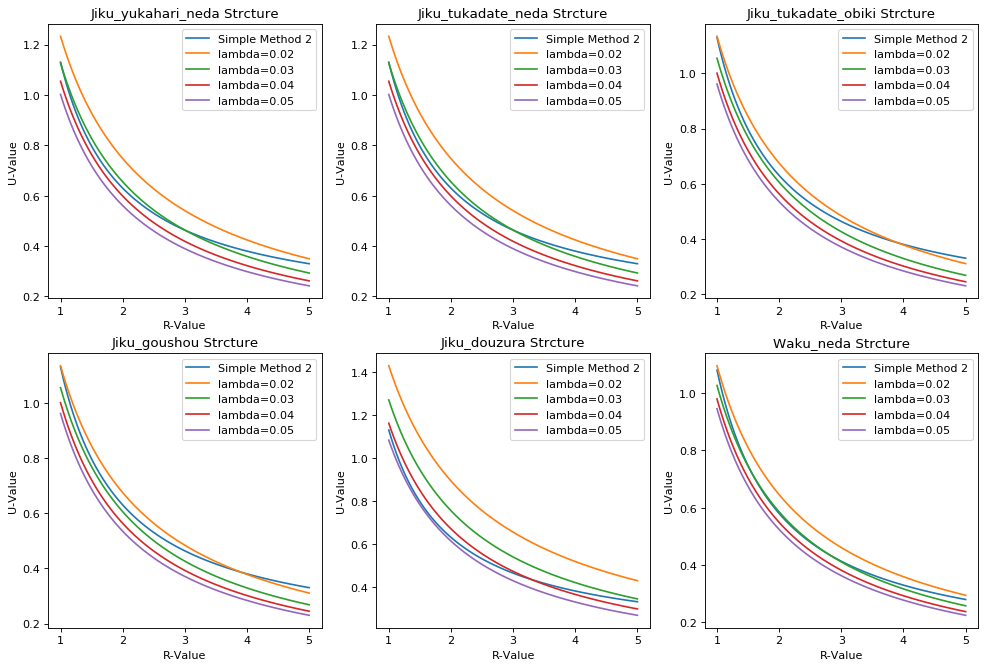

In [30]:
plt.figure(figsize=(15,10),dpi=80)

R = np.linspace(1,5,100)

plt.subplot(231)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jiku_yukahari_neda Strcture')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Jiku_yukahari_neda', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(232)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jiku_tukadate_neda Strcture')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Jiku_tukadate_neda', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(233)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jiku_tukadate_obiki Strcture')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Jiku_tukadate_obiki', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(234)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jiku_goushou Strcture')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Jiku_goushou', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(235)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Jiku_douzura Strcture')
plt.plot( R, 1/R+0.13, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Jiku_douzura', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.subplot(236)
plt.xlabel('R-Value')
plt.ylabel('U-Value')
plt.title('Waku_neda Strcture')
plt.plot( R, 1/R+0.08, label = 'Simple Method 2')
for l in [ 0.02, 0.03, 0.04, 0.05 ]:
    plt.plot( R, U_floor_simple( True, 'Waku_neda', l, l*R, 0, 0 ), label = 'lambda='+str(l) )
plt.legend()

plt.show()

## 4) 窓

### 基本式

窓のU値は以下の式で与えられる。

$\begin{align} U_w = \frac{ \sum{A_f U_f} + \sum{l_g \psi_g } + A_g U_g }{ \sum{A_f} + A_g } \end{align}$

ここで、  
$U$:熱貫流率(W/m<sup>2</sup>K)  
$\psi$:線熱貫流率(W/mK)  
$A$:面積(m<sup>2</sup>)  
$l$:長さ(m)  
w:窓  
f:建具(フレームとサッシ)
g:グレージング(ガラス)

In [31]:
def U_window( Af, Uf, lg, psig, Ag, Ug ):
    # Af: 建具の面積 (m2) (array型)
    # Uf: 建具の熱貫流率 (W/m2K)
    # lg: グレージング周囲の長さ (m) (array型)
    # psig: グレージング周囲の線熱貫流率 (W/mK)
    # Ag: グレージングの面積 (m2)
    # Ug: グレージングの熱貫流率 (W/m2K)
    return ( ( Af * Uf ).sum() + ( lg * psig ).sum() + Ag * Ug ) / ( Af.sum() + Ag ) 

### 窓の形状(建具の面積、グレージング周囲の長さ、グレージングの面積)

建具の種類に応じてデフォルト形状を設定する。

建具・グレージングの面積

| 部分           | 木製建具・樹脂製建具 | 木と金属の複合材料製建具・樹脂と金属の複合材料製建具 | 金属製建具 |
|:--------------:|:--------------------:|:----------------------------------------------------:|:----------:|
| 内側窓上部分   | 0.119 | 0.064 | 0.071 |
| 内側窓下部分   | 0.121 | 0.069 | 0.081 |
| 内側窓縦部分   | 0.117 | 0.079 | 0.052 |
| めしあわせ部分 | 0.08  | 0.04  | 0.03  |
| 外側窓上部分   | 0.119 | 0.064 | 0.071 |
| 外側窓下部分   | 0.121 | 0.069 | 0.081 |
| 外側窓縦部分   | 0.117 | 0.079 | 0.052 |
| グレージング   | 1.531 | 1.853 | 1.883 |

グレージング周囲の長さ

| 部分           | 木製建具・樹脂製建具 | 木と金属の複合材料製建具・樹脂と金属の複合材料製建具 | 金属製建具 |
|:--------------:|:--------------------:|:----------------------------------------------------:|:----------:|
| 内側窓上部分       | 0.69 | 0.77 | 0.78 |
| 内側窓下部分       | 0.69 | 0.77 | 0.78 |
| 内側窓縦部分       | 1.13 | 1.21 | 1.22 |
| 内側めしあわせ部分 | 1.13 | 1.21 | 1.22 |
| 外側窓上部分       | 0.69 | 0.77 | 0.78 |
| 外側窓下部分       | 0.69 | 0.77 | 0.78 |
| 外側窓縦部分       | 1.13 | 1.21 | 1.22 |
| 外側めしあわせ部分 | 1.13 | 1.21 | 1.22 |


### 窓の物性値

建具の種類に応じて、デフォルト値を設定する。

| 部分           | 木製建具・樹脂製建具 | 木と金属の複合材料製建具・樹脂と金属の複合材料製建具 | 金属製建具 |
|:--------------:|:--------------------:|:----------------------------------------------------:|:----------:|
| 建具の熱貫流率 (W/m2K)              | 2.379 | 4.367 | 7.349 |
| グレージング周囲の線熱貫流率 (W/mK) | 0.07  | 0.08  | 0.035 |

In [32]:
class WindowShapeAndSpec(Enum):
    WoodResin = 1
    Complex = 2
    Metal = 3
    
    def get_Af(self):
        return np.array( [ [ 0.119, 0.121, 0.117, 0.08, 0.119, 0.121, 0.117 ],
                           [ 0.064, 0.069, 0.079, 0.04, 0.064, 0.069, 0.079 ],
                           [ 0.071, 0.081, 0.052, 0.03, 0.071, 0.081, 0.052 ] ] )[self.value-1]
    
    def get_Ag(self):
        return ( [ 1.531, 1.853, 1.883 ] )[self.value-1]
    
    def get_lg(self):
        return np.array( [ [ 0.69, 0.69, 1.13, 1.13, 0.69, 0.69, 1.13, 1.13 ],
                           [ 0.77, 0.77, 1.21, 1.21, 0.77, 0.77, 1.21, 1.21 ],
                           [ 0.78, 0.78, 1.22, 1.22, 0.78, 0.78, 1.22, 1.22 ] ] )[self.value-1]
    
    def get_Uf(self):
        return ( [ 2.379, 4.367, 7.349 ] )[self.value-1]
    
    def get_psig(self):
        return ( [ 0.07, 0.08, 0.035 ] )[self.value-1]
    
    def get_Uw(self, Ug):
        return U_window( self.get_Af(), self.get_Uf(), self.get_lg(), self.get_psig(), self.get_Ag(), Ug )

In [33]:
WindowShapeAndSpec.WoodResin.get_Uw(3.0)

3.0071079569892474

In [34]:
WindowShapeAndSpec.Complex.get_Uw(3.0)

3.5472110487699609

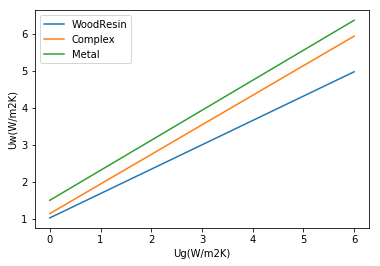

In [35]:
Ug = np.linspace(0,6,100)

plt.xlabel('Ug(W/m2K)')
plt.ylabel('Uw(W/m2K)')
plt.plot( Ug, WindowShapeAndSpec.WoodResin.get_Uw(Ug), label = 'WoodResin' )
plt.plot( Ug, WindowShapeAndSpec.Complex.get_Uw(Ug),   label = 'Complex'   )
plt.plot( Ug, WindowShapeAndSpec.Metal.get_Uw(Ug),     label = 'Metal'     )
plt.legend()
plt.show()

### テスト

In [36]:
test_window_input = []

    # 第1引数 w: 建具の種類 (クラス(Enum)WoodShapeAndSpec型)
    # 第2引数 Ug: グレージングの熱貫流率(W/m2K)

test_window_input.append( [ WindowShapeAndSpec.WoodResin, 3.0] )
test_window_input.append( [ WindowShapeAndSpec.Complex,   3.0] )
test_window_input.append( [ WindowShapeAndSpec.Metal,     3.0] )

In [37]:
test_window_output = []
for t in test_window_input:
    test_window_output.append( [ str(t[0].name), 'Ug='+str(t[1]), t[0].get_Uw(t[1]) ] )
test_window_output

[['WoodResin', 'Ug=3.0', 3.0071079569892474],
 ['Complex', 'Ug=3.0', 3.5472110487699609],
 ['Metal', 'Ug=3.0', 3.9413451098664365]]

## 5) ドア

### 基本式

ドアのU値は以下の式で与えられる。

$\begin{align} U_d = \frac{ A_g U_g + A_p U_p + \sum{A_f U_f} + \sum{l_g \psi_g } + \sum{l_f \psi_{pf} } + \sum{l_g \psi_{pg} } + \sum \chi }{ A_g + A_p + \sum{A_f} } \end{align}$

ここで、  
$U$:熱貫流率(W/m<sup>2</sup>K)  
$\psi$:線熱貫流率(W/mK)  
$\chi$:点熱貫流率(W/K)  
$A$:面積(m<sup>2</sup>)  
$l$:長さ(m)  
w:ドア  
f:枠  
p:不透明パネル  
pf:不透明パネルの枠側  
pg:不透明パネルのグレージング側  
g:グレージング(ガラス)

グレージングの線熱貫流率($\psi_g$)は、グレージングが有る場合のみその周囲に対して発生する。  
不透明パネルの線熱貫流率($\psi_p$)は、不透明パネルの周囲で必ず発生し、加えてグレージングが有る場合はその周囲に対して発生する。

### ドアの形状

グレージングの有無に応じてデフォルト形状を設定する。

| 部分                          | 記号  | グレージング有 | グレージング無 |
|:-----------------------------:|:-----:|:--------------:|:--------------:|
| グレージング面積(m2)          | $A_g$ | 0.30 | 0.00 |
| 不透明パネル面積(m2)          | $A_p$ | 1.72 | 2.02 |
| 枠面積(上)(m2)                | $A_f$ | 0.03 | 0.03 |
| 枠面積(下)(m2)                | $A_f$ | 0.00 | 0.00 |
| 枠面積(縦(吊元))(m2)          | $A_f$ | 0.10 | 0.10 |
| 枠面積(縦(戸先))(m2)          | $A_f$ | 0.10 | 0.10 |
| グレージング周長(上)(m)       | $l_g$ | 0.15 | 0.00 |
| グレージング周長(下)(m)       | $l_g$ | 0.15 | 0.00 |
| グレージング周長(縦(吊元))(m) | $l_g$ | 2.00 | 0.00 |
| グレージング周長(縦(戸先))(m) | $l_g$ | 2.00 | 0.00 |
| 不透明パネル周長(上)(m)       | $l_f$ | 0.86 | 0.86 |
| 不透明パネル周長(下)(m)       | $l_f$ | 0.86 | 0.86 |
| 不透明パネル周長(縦(吊元))(m) | $l_f$ | 2.34 | 2.34 |
| 不透明パネル周長(縦(戸先))(m) | $l_f$ | 2.34 | 2.34 |

In [88]:
class DoorShape(Enum):
    GlazingAttached = 1
    NoGlazing = 2
    
    def get_Ag(self):
        return [ 0.30, 0.00 ][self.value-1]
    def get_Ap(self):
        return [ 1.72, 2.02 ][self.value-1]
    def get_Af(self):
        return np.array( ( 0.03, 0.00, 0.10, 0.10 ) )
    def get_lg(self):
        return np.array( [ ( 0.15, 0.15, 2.00, 2.00 ), ( 0.00, 0.00, 0.00, 0.00 ) ][self.value-1] )
    def get_lf(self):
        return np.array( ( 0.86, 0.86, 2.34, 2.34 ) )

### 不透明パネルの物性値

不透明パネルの種類に応じてデフォルト値を設定する。

| 不透明パネルの部分 | 記号 | 金属製高断熱F構造 | 金属製断熱F構造 | 金属製F構造 | 金属製HF構造 | 金属製又はその他 |
|:------------------:|:----:|:-----------------:|:---------------:|:-----------:|:------------:|:----------------:|
| 熱貫流率(W/m2K)                          | $U_p$       | 0.56 | 0.81 | 0.81 | 1.74 | 5.61 |
| 枠側の線熱貫流率(上側)(W/mK)             | $\psi_{pf}$ | 0.10 | 0.11 | 0.11 | 0.01 | 0.02 |
| 枠側の線熱貫流率(下側)(W/mK)             | $\psi_{pf}$ | 0.09 | 0.08 | 0.08 | 0.12 | 0.02 |
| 枠側の線熱貫流率(吊元側)(W/mK)           | $\psi_{pf}$ | 0.12 | 0.21 | 0.27 | 0.25 | 0.02 |
| 枠側の線熱貫流率(戸先側)(W/mK)           | $\psi_{pf}$ | 0.10 | 0.24 | 0.29 | 0.30 | 0.02 |
| グレージング側の線熱貫流率(上側)(W/mK)   | $\psi_{pg}$ | 0.05 | 0.07 | 0.07 | 0.14 | 0.00 |
| グレージング側の線熱貫流率(下側)(W/mK)   | $\psi_{pg}$ | 0.05 | 0.07 | 0.07 | 0.14 | 0.00 |
| グレージング側の線熱貫流率(吊元側)(W/mK) | $\psi_{pg}$ | 0.08 | 0.11 | 0.11 | 0.13 | 0.00 |
| グレージング側の線熱貫流率(戸先側)(W/mK) | $\psi_{pg}$ | 0.08 | 0.11 | 0.11 | 0.13 | 0.00 |

※ F構造 ... フラッシュ構造  
※ HF構造 ... ハニカムフラッシュ構造  

In [57]:
class DoorPanelType(Enum):
    MHIF = 1
    MIF  = 2
    MF   = 3
    MHF  = 4
    M    = 5
    
    def get_Up(self):
        return np.array( [ 0.56, 0.81, 0.81, 1.74, 5.61 ][self.value-1] )
    def get_psi_pf(self):
        return np.array( [ ( 0.10, 0.09, 0.12, 0.10 ),
                           ( 0.11, 0.08, 0.21, 0.24 ),
                           ( 0.11, 0.08, 0.27, 0.29 ),
                           ( 0.01, 0.12, 0.25, 0.30 ),
                           ( 0.02, 0.02, 0.02, 0.02 ) ][self.value-1] )
    def get_psi_pg(self):
        return np.array( [ ( 0.05, 0.05, 0.08, 0.08 ),
                           ( 0.07, 0.07, 0.11, 0.11 ),
                           ( 0.07, 0.07, 0.11, 0.11 ),
                           ( 0.14, 0.14, 0.13, 0.13 ),
                           ( 0.00, 0.00, 0.00, 0.00 ) ][self.value-1] )

### 枠の物性値

枠の種類に応じてデフォルト値を設定する。

| 枠  | 記号 | 木製 | 金属製熱遮断構造 | 木と金属との複合材料製または樹脂と金属との複合材料製 | 金属製又はその他 |
|:---:|:----:|:----:|:----------------:|:----------------------------------------------------:|:----------------:|
| 上側(W/m2K)   | $U_f$ | 1.45 |    4.12 |    4.49 |   5.56 |
| 下側(W/m2K)   | $U_f$ | 2.25 | 6635.42 | 6254.52 | 410.49 |
| 吊元側(W/m2K) | $U_f$ | 1.43 |    4.34 |    5.32 |   5.67 |
| 戸先側(W/m2K) | $U_f$ | 1.45 |    4.15 |    3.47 |   5.49 |

In [96]:
class DoorFrameType(Enum):
    Wood     = 1
    InsMetal = 2
    Complex  = 3
    Metal    = 4
    
    def get_Uf(self):
        return np.array( [ ( 1.45,    2.25, 1.43, 1.45 ),
                           ( 4.12, 6635.42, 4.34, 4.15 ),
                           ( 4.49, 6254.52, 5.32, 3.47 ),
                           ( 5.56,  410.49, 5.67, 5.49 ) ][self.value-1] )

### グレージング

グレージングの熱貫流率($U_g$)は入力値とする。  
グレージングの周囲の線熱貫流率($\psi_g$)は平均値とし、グレージング、スペーサー・フレームの組み合わせによらず、0.11とする。

### その他

錠1つにつき点熱貫流率($\chi$)は、0.22とする。  
ポストがある場合はその影響を点熱貫流率で表し、0.10とする。

In [118]:
def U_door( Ug, ds, dpt, dft, num_of_lock, num_of_post ):
    q = ds.get_Ag() * Ug \
      + ds.get_Ap() * dpt.get_Up() \
      + ( ds.get_Af() * dft.get_Uf() ).sum() \
      + ( ds.get_lg() * 0.11 ).sum() \
      + ( ds.get_lf() * dpt.get_psi_pf() ).sum() \
      + ( ds.get_lg() * dpt.get_psi_pg() ).sum() \
      + num_of_lock * 0.22 \
      + num_of_post * 0.10
    A = ds.get_Ag() + ds.get_Ap() + ( ds.get_Af() ).sum()
    return ( "Ug_Coeff: "+str(ds.get_Ag()), \
             "qd: "+str( ds.get_Ap() * dpt.get_Up() + ( ds.get_lf() * dpt.get_psi_pf() ).sum() + ( ds.get_lg() * dpt.get_psi_pg() ).sum() ), \
             "qf: "+str( ( ds.get_Af() * dft.get_Uf() ).sum() ), \
             "q0: "+str( ( ds.get_lg() * 0.11 ).sum() + num_of_lock * 0.22 + num_of_post * 0.10 ), \
             "A: "+str( A ),
             q/A)

In [119]:
U_door( 3.0, DoorShape.GlazingAttached, DoorPanelType.M, DoorFrameType.Metal, 2,1 )

('Ug_Coeff: 0.3',
 'qd: 9.7772',
 'qf: 1.2828',
 'q0: 1.013',
 'A: 2.25',
 5.7657777777777781)

### テスト

In [122]:
test_door_input = []

    # 第1引数 Ug: グレージングの熱貫流率(W/m2K)
    # 第2引数 ds: ドアの種類(ガラスの有無)(クラス(Enum)DoorShape型)
    # 第3引数 dpt: 不透明パネルの種類(クラス(Enum)DoorPanelType型)
    # 第4引数 dft: ドアのフレームの種類(クラス(Enum)DoorFrameType型)
    # 第5引数 num_of_lock: 錠の数(通常、0,1,2)
    # 第6引数 num_of_post: ポストの数(通常、0,1)

# 基本パターン
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Metal, 0, 0 ] )
# ガラスの有無を変更
test_door_input.append( [ 3.0, DoorShape.GlazingAttached, DoorPanelType.M, DoorFrameType.Metal, 0, 0 ] )
# 不透明パネルの種類を変更
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.MHIF, DoorFrameType.Metal, 0, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.MIF, DoorFrameType.Metal, 0, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.MHF, DoorFrameType.Metal, 0, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.MF, DoorFrameType.Metal, 0, 0 ] )
# ドアの枠の種類を変更
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Wood, 0, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Complex, 0, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.InsMetal, 0, 0 ] )
# 錠の数を変更
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Metal, 1, 0 ] )
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Metal, 2, 0 ] )
# ポストの数を変更
test_door_input.append( [ 3.0, DoorShape.NoGlazing, DoorPanelType.M, DoorFrameType.Metal, 0, 1 ] )


In [127]:
test_door_output = []
for t in test_door_input:
    test_door_output.append( ( 'Ug='+str(t[0]), 'ガラスの有無='+str(t[1].name), '不透明パネルの種類='+str(t[2].name), '枠の種類='+str(t[3].name), '錠の数='+str(t[4]), 'ポストの数='+str(t[5]), U_door(t[0],t[1],t[2],t[3],t[4],t[5]) ) )
test_door_output

[('Ug=3.0',
  'ガラスの有無=NoGlazing',
  '不透明パネルの種類=M',
  '枠の種類=Metal',
  '錠の数=0',
  'ポストの数=0',
  ('Ug_Coeff: 0.0',
   'qd: 11.4602',
   'qf: 1.2828',
   'q0: 0.0',
   'A: 2.25',
   5.6635555555555559)),
 ('Ug=3.0',
  'ガラスの有無=GlazingAttached',
  '不透明パネルの種類=M',
  '枠の種類=Metal',
  '錠の数=0',
  'ポストの数=0',
  ('Ug_Coeff: 0.3',
   'qd: 9.7772',
   'qf: 1.2828',
   'q0: 0.473',
   'A: 2.25',
   5.5257777777777788)),
 ('Ug=3.0',
  'ガラスの有無=NoGlazing',
  '不透明パネルの種類=MHIF',
  '枠の種類=Metal',
  '錠の数=0',
  'ポストの数=0',
  ('Ug_Coeff: 0.0',
   'qd: 1.8094',
   'qf: 1.2828',
   'q0: 0.0',
   'A: 2.25',
   1.374311111111111)),
 ('Ug=3.0',
  'ガラスの有無=NoGlazing',
  '不透明パネルの種類=MIF',
  '枠の種類=Metal',
  '錠の数=0',
  'ポストの数=0',
  ('Ug_Coeff: 0.0',
   'qd: 2.8526',
   'qf: 1.2828',
   'q0: 0.0',
   'A: 2.25',
   1.8379555555555553)),
 ('Ug=3.0',
  'ガラスの有無=NoGlazing',
  '不透明パネルの種類=MHF',
  '枠の種類=Metal',
  '錠の数=0',
  'ポストの数=0',
  ('Ug_Coeff: 0.0',
   'qd: 4.9136',
   'qf: 1.2828',
   'q0: 0.0',
   'A: 2.25',
   2.753955555555555